# Modelling and Deployment using MLOps 

Now that we have audio input data & corresponding labels in an array format, it is easier to consume and apply Natural language processing techniques. We can convert audio files labels into integers using label Encoding or One Hot Vector Encoding for machines to learn. The labeled dataset will help us in the neural network model output layer for predicting results. These help in training & validation datasets into nD array.
At this stage, we apply other pre-processing techniques like dropping columns, normalization, etc. to conclude our final training data for building models. Moving to the next stage of splitting the dataset into train, test, and validation is what we have been doing for other models. 
We can leverage CNN, RNN, LSTM,CTC etc. deep neural algorithms to build and train the models for speech applications like speech recognition. The model trained with the standard size few seconds audio chunk transformed into an array of n dimensions with the respective labels will result in predicting output labels for test audio input. As output labels will vary beyond binary, we are talking about building a multi-class label classification method.


In [4]:
import pandas as pd
import numpy as np
import os,sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
sys.path.append(os.path.abspath(os.path.join('../scripts')))
import tensorflow as tf
from clean import Clean
from utils import vocab
from deep_learner import DeepLearn
from modeling import Modeler
from validators import CallbackEval

ImportError: cannot import name 'CallbackEval' from 'validators' (/home/martin/Documents/swahili_nlp/env/lib/python3.10/site-packages/validators/__init__.py)

In [2]:
AM_ALPHABET='ሀለሐመሠረሰቀበግዕዝተኀነአከወዐዘየደገጠጰጸፀፈፐቈኈጐኰፙፘፚauiāeəo'
EN_ALPHABET='abcdefghijklmnopqrstuvwxyz'

In [3]:
cleaner = Clean()
char_to_num,num_to_char=vocab(AM_ALPHABET)

2022-06-02 07:50:53,939:logger:Successfully initialized clean class


The vocabulary is: ['', 'ሀ', 'ለ', 'ሐ', 'መ', 'ሠ', 'ረ', 'ሰ', 'ቀ', 'በ', 'ግ', 'ዕ', 'ዝ', 'ተ', 'ኀ', 'ነ', 'አ', 'ከ', 'ወ', 'ዐ', 'ዘ', 'የ', 'ደ', 'ገ', 'ጠ', 'ጰ', 'ጸ', 'ፀ', 'ፈ', 'ፐ', 'ቈ', 'ኈ', 'ጐ', 'ኰ', 'ፙ', 'ፘ', 'ፚ', 'a', 'u', 'i', 'ā', 'e', 'ə', 'o'] (size =44)


# Deep Learning Model

**objective**: Build a Deep learning model that converts speech to text.

In [4]:
swahili_df = pd.read_csv("../data/swahili.csv")
amharic_df = pd.read_csv("../data/amharic.csv")

In [5]:
pre_model = Modeler()

In [6]:
swahili_preprocessed = pre_model.preprocessing_learn(swahili_df,'key','file')

In [7]:
amharic_preprocessed = pre_model.preprocessing_learn(amharic_df,'key','file')

In [8]:
train_df,val_df,test_df = amharic_preprocessed

In [9]:
batch_size = 32
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(train_df["file"]), list(train_df["text"]))
)
train_dataset = (
    train_dataset.map(cleaner.encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(val_df["file"]), list(val_df["text"]))
)
validation_dataset = (
    validation_dataset.map(cleaner.encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


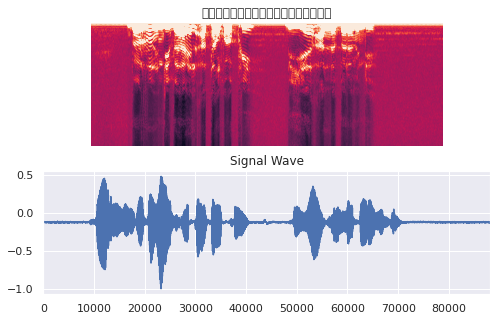

In [10]:
import matplotlib.pyplot as plt
from IPython import display
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(list(train_df["file"])[0])
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

## LSTM Deep Learning

In [13]:
learn = DeepLearn(input_width=1, label_width=1, shift=1,epochs=5,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=['mfcc-0'])
fft_length = 384
model = learn.build_asr_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)
# predictions = learn.model(
#     model_=model
# )

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

# Evaluation

**objective**: Evaluate your model. 

In [11]:
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

[[[0.11674367636442184]],
 [[0.11674367636442184]],
 [[0.11674367636442184]],
 [[0.11674367636442184]],
 [[0.11674367636442184]],
 [[0.11674367636442184]]]